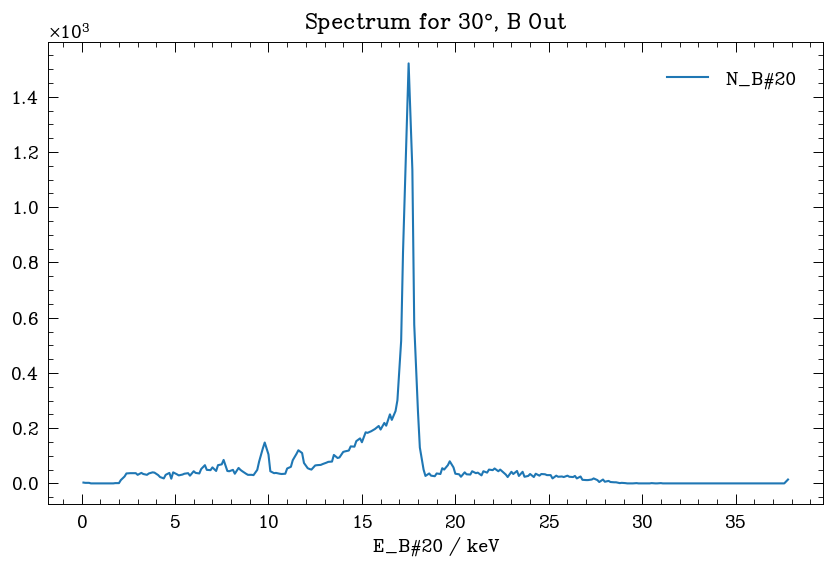

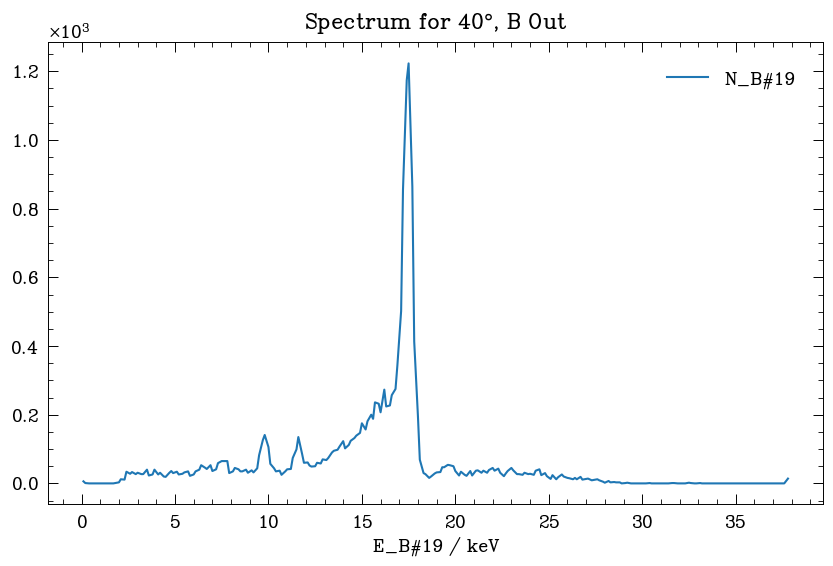

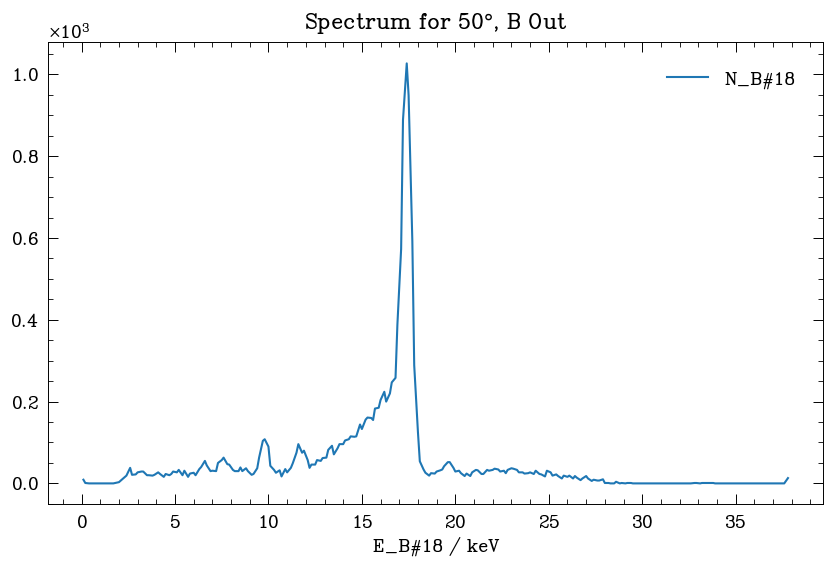

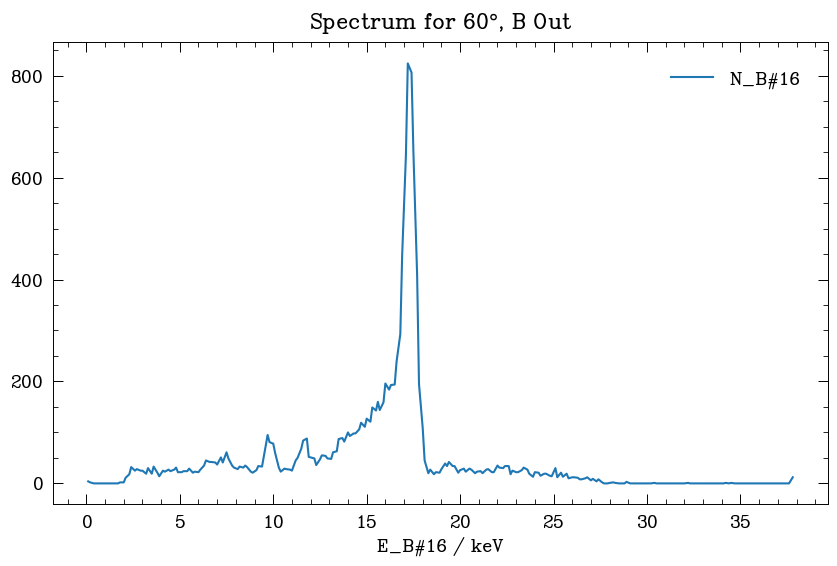

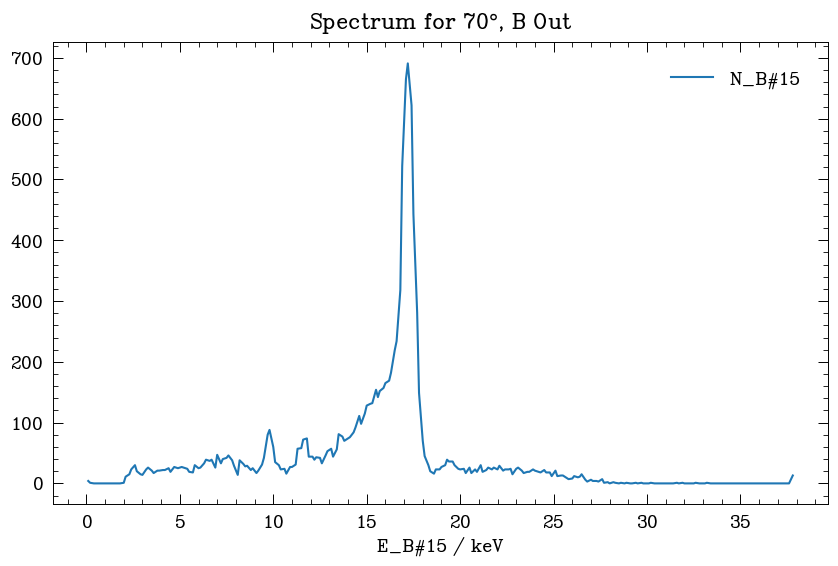

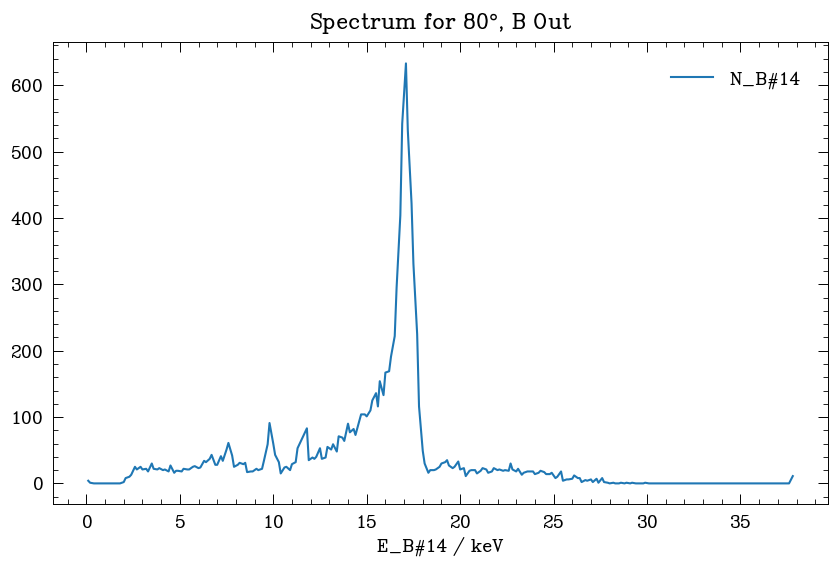

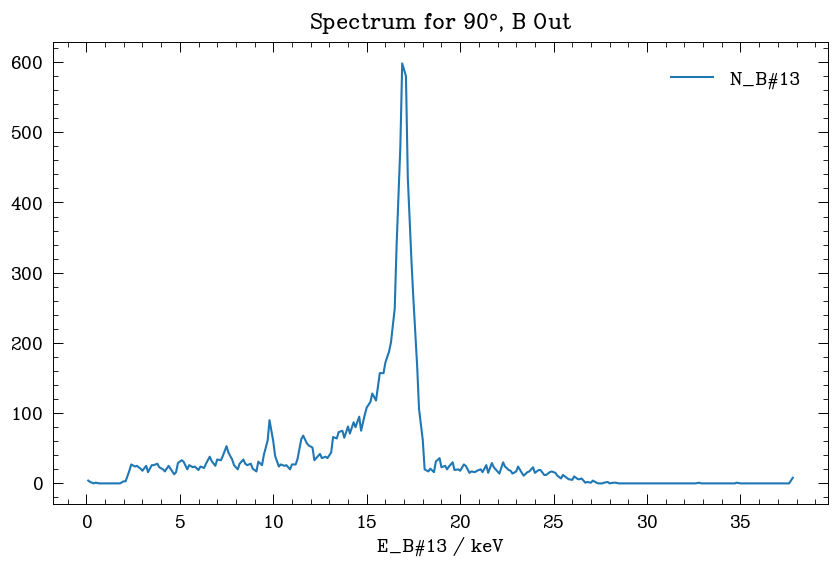

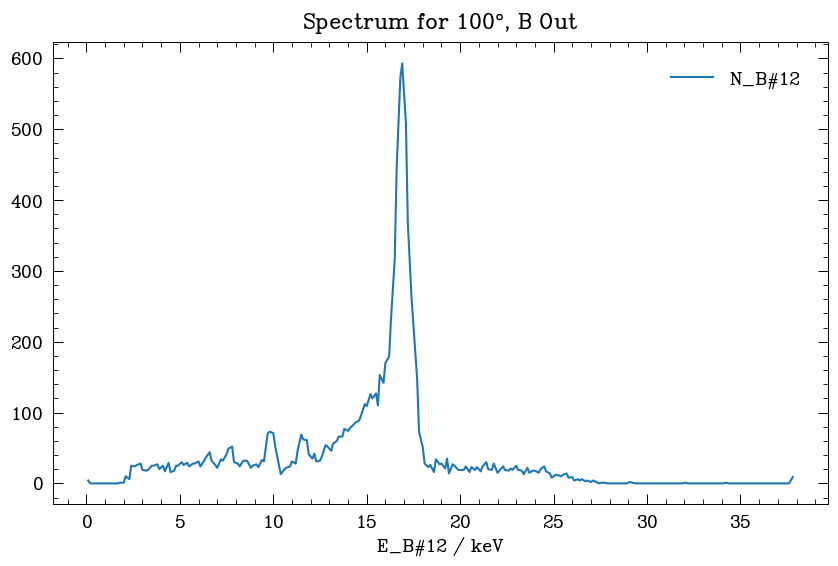

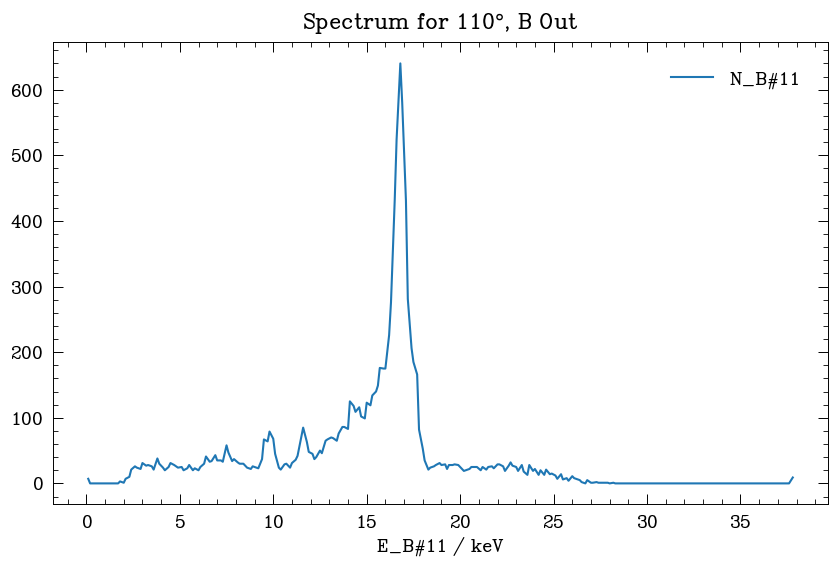

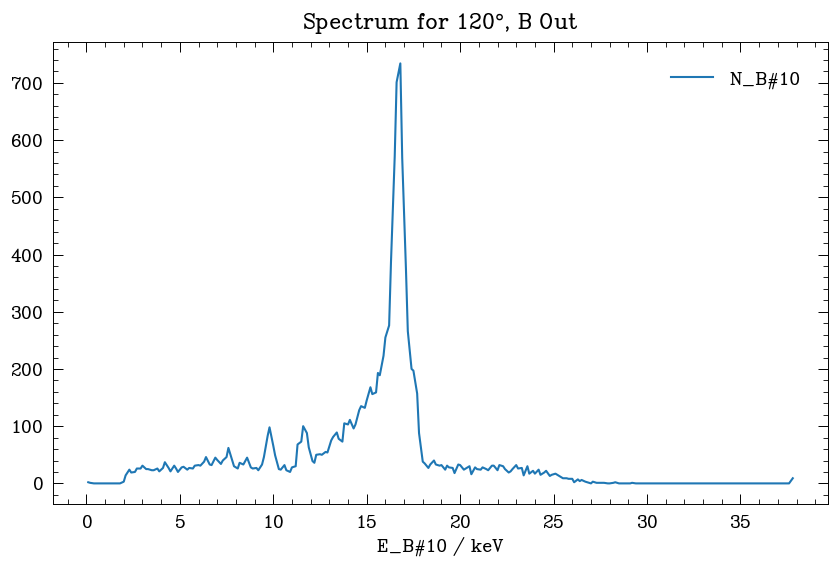

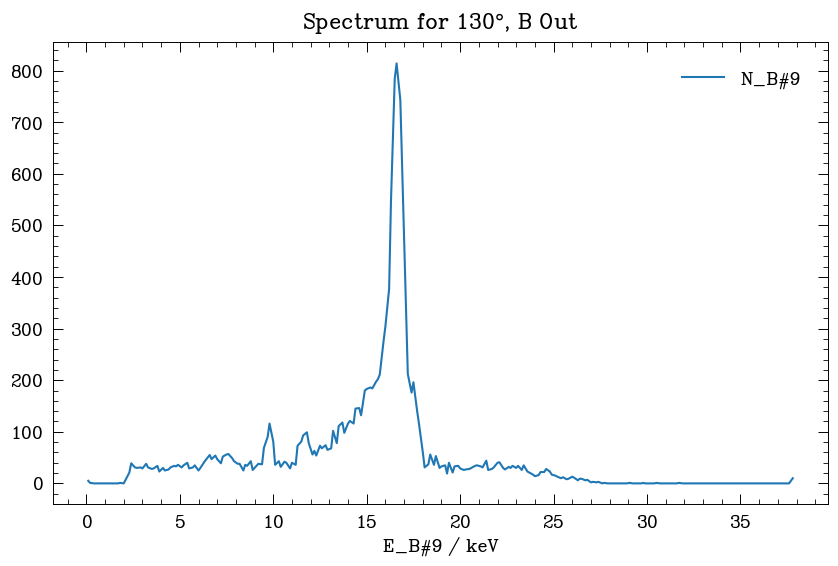

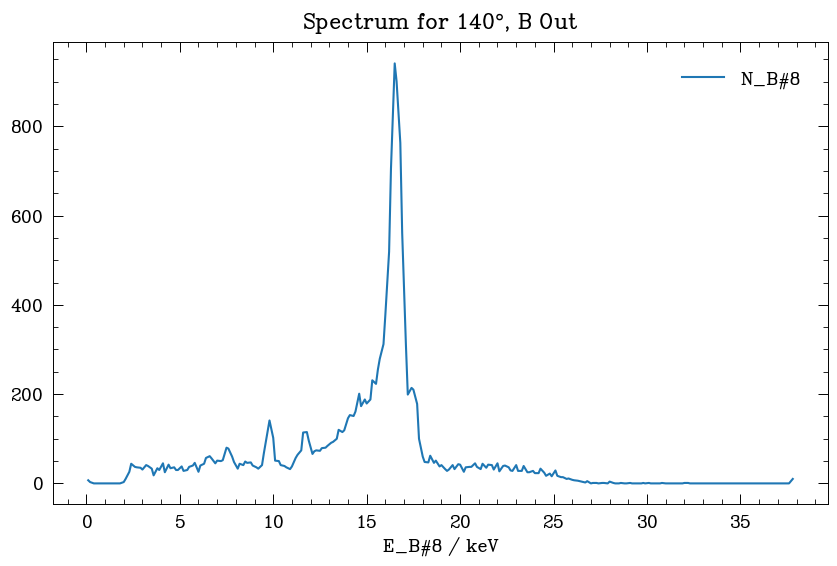

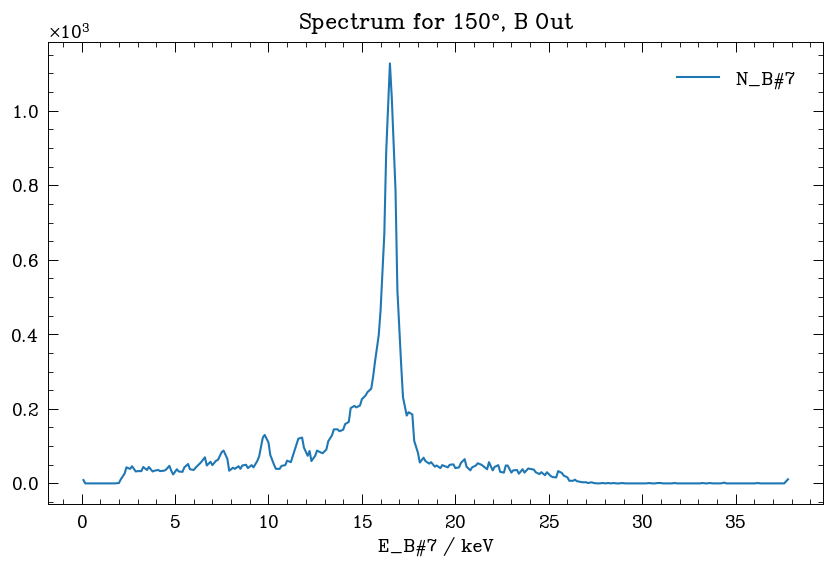

In [2]:
import pandas as pd
import smplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

ns = np.arange(30,160,10).astype(int)

dfs = {}

for n in ns:
    df = pd.read_csv('Data/Plexiglass/Circle Collimator 30kEv 1mA/'+str(n)+'.txt', sep='\t')

    df.plot(x=0,y=1,figsize=(10,6))
    plt.title(r'Spectrum for $%d\degree$, B Out' % n)
    plt.show()
    dfs[n] = df

['Thetas, Counts, Uncertainty\n', '8611.000000, 19.344066\n', '7816.000000, 18.972837\n', '6822.000000, 18.348719\n', '5939.000000, 17.757535\n', '5276.000000, 17.289953\n', '4767.000000, 16.840187\n', '4661.000000, 16.775478\n', '4620.000000, 16.714476\n', '4837.000000, 16.933079\n', '5515.000000, 17.462845\n', '6240.000000, 18.001613\n', '7042.000000, 18.565845\n', '7986.000000, 19.128578\n']


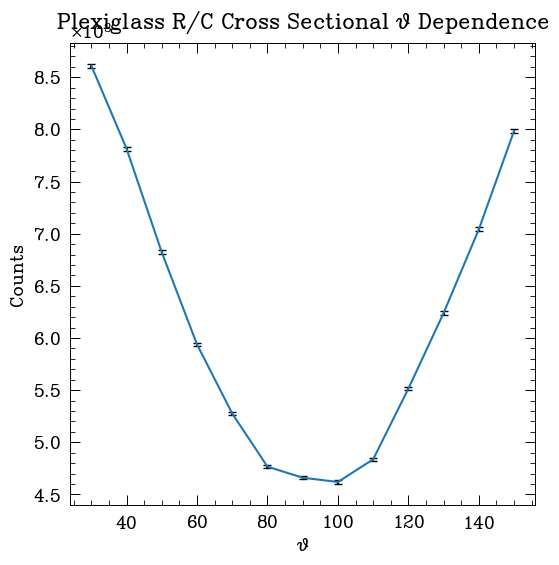

In [3]:
integrals = []
errors = []
peaksP = {}
lines = ['Thetas, Counts, Uncertainty\n']
for n in ns:
    Es = dfs[n].iloc[:,0].to_numpy()
    counts = dfs[n].iloc[:,1].to_numpy()
    
    peaks_t = []
    Epeaks = []
    for i,E in enumerate(Es):
        #bounds for peaks
        if E > 15.5 and E < 18.5:
            peaks_t.append(counts[i])
            Epeaks.append(E)
    peaks_t = np.array(peaks_t)
    peaksP[n] = peaks_t,Epeaks
    errors.append(np.sqrt(np.sum(np.sqrt(peaks_t))))
    integrals.append(peaks_t.sum())
    lines.append('%f, %f\n' % (integrals[-1],errors[-1]))

print(lines)
    
plt.errorbar(ns,integrals,yerr=errors,ecolor='black')
plt.xlabel(r'$\theta$')
plt.ylabel('Counts')
plt.title(r'Plexiglass R/C Cross Sectional $\theta$ Dependence')
plt.show()        

In [4]:
import scipy as sp

def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

m_e = 511
kA_Mo = 17.479372

def compton_shift(theta, E_0):
    return E_0/(1+E_0/m_e*(1-np.cos(np.pi/180*theta)))

def red_chi_2(f,y,y_err):
    return np.sum(((y-f)**2)/(y_err**2))/len(y)

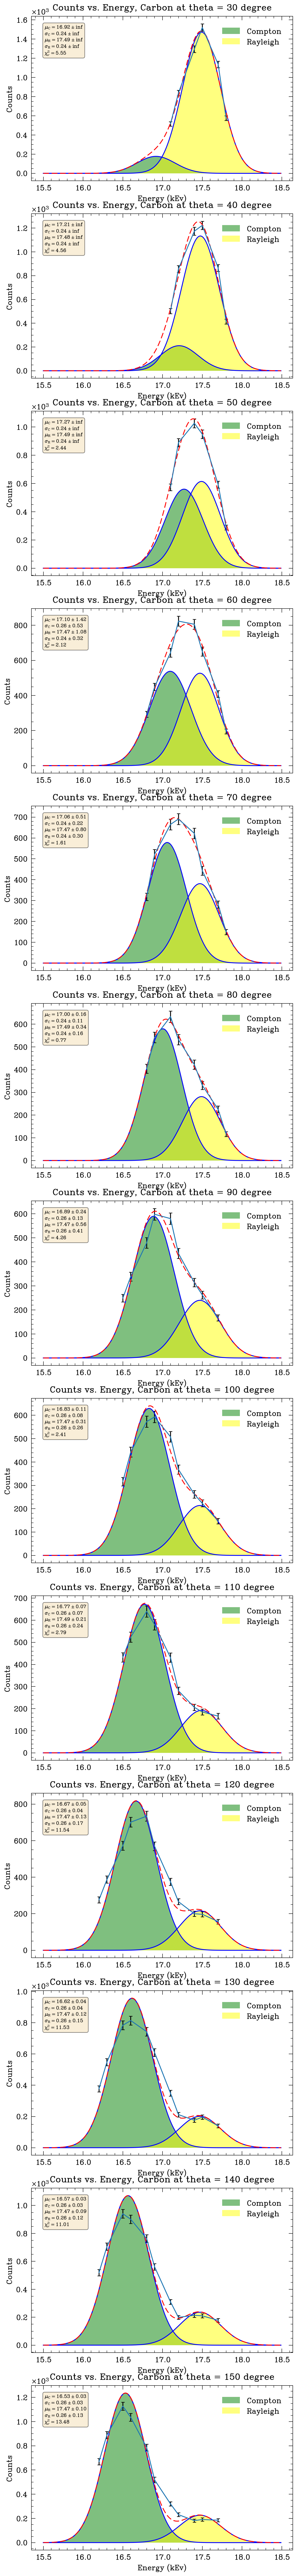

In [13]:
pars = {}
perrs = {}

ptrim = [
    #30
    [10,1],
    #40
    [10,1],
    #50
    [10,1],
    #60
    [8,1],
    #70
    [8,1],
    #80
    [8,1],
    #90
    [6,2],
    #100
    [6,2],
    #110
    [6,2],
    #120
    [4,2],
    #130
    [4,2],
    #140
    [4,2],
    #150
    [4,2]
]
ptrim = dict(zip(ns, ptrim))
peaks_modified = {}

fig,ax = plt.subplots(len(ns),figsize=(8,6*len(ns)),dpi=200)

for j,n in enumerate(ns):
    peaks,Es = peaksP[n]
    Es = np.array(Es)[ptrim[n][0]:-ptrim[n][1]-3]
    peaks = np.array(peaks)[ptrim[n][0]:-ptrim[n][1]-3]
    peaks_modified[n] = peaks,Es
    amp1 = 500*(1+np.cos(n*np.pi/180)**2)/2
    cen1 = compton_shift(n, kA_Mo)
    sigma1 = 0.25
    
    if n > 5:
        amp2 = amp1/5
        cen2 = 17.48
        sigma2 = sigma1
        
        bounds = ([0,cen1-0.5,sigma1-0.01,0,cen2-0.01,sigma2-0.01],[2000,cen1+0.5,sigma1+0.01,2000,cen2+0.01,sigma2+0.01])
        
        popt_2gauss, pcov_2gauss = sp.optimize.curve_fit(_2gaussian, Es, peaks, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2],sigma=np.sqrt(peaks),bounds = bounds)
        perr_2gauss = np.sqrt(np.diag(pcov_2gauss))
        pars_1 = popt_2gauss[0:3]
        perr_1 = perr_2gauss[0:3]
        pars_2 = popt_2gauss[3:6]
        perr_2 = perr_2gauss[3:6]
        gauss_peak_1 = _1gaussian(np.arange(15.5,18.5,0.01), *pars_1)
        gauss_peak_2 = _1gaussian(np.arange(15.5,18.5,0.01), *pars_2)
    
        pars[n] = popt_2gauss
        perrs[n] = perr_2gauss
    
        mu1 = pars_1[1]
        muE1 = perr_1[1]
        sigma1 = pars_1[2]
        sigmaE1 = perr_1[2]
        mu2 = pars_2[1]
        muE2 = perr_2[1]
        sigma2 = pars_2[2]
        sigmaE2 = perr_2[2]
        
        chi = red_chi_2(_1gaussian(Es, *pars_2)+_1gaussian(Es, *pars_1),peaks,np.sqrt(peaks))
        
        textstr = '\n'.join((
            r'$\mu_C=%.2f\pm %.2f$' % (mu1, muE1),
            r'$\sigma_C=%.2f\pm %.2f$' % (sigma1, sigmaE1),
            r'$\mu_R=%.2f\pm %.2f$' % (mu2, muE2),
            r'$\sigma_R=%.2f\pm %.2f$' % (sigma2, sigmaE2),
            r'$\chi^2_{\nu}=%.2f$' % (chi, )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax[j].text(0.05, 0.95, textstr, transform=ax[j].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    
        ax[j].errorbar(Es,peaks,yerr=np.sqrt(peaks),ecolor='black')
        ax[j].plot(np.arange(15.5,18.5,0.01),gauss_peak_1,'b-')
        ax[j].plot(np.arange(15.5,18.5,0.01),gauss_peak_2,'b-')
        ax[j].plot(np.arange(15.5,18.5,0.01),gauss_peak_1+gauss_peak_2,'r--')
        ax[j].fill_between(np.arange(15.5,18.5,0.01), gauss_peak_1.min(), gauss_peak_1, facecolor="green",label='Compton', alpha=0.5) 
        ax[j].fill_between(np.arange(15.5,18.5,0.01), gauss_peak_2.min(), gauss_peak_2, facecolor="yellow",label='Rayleigh', alpha=0.5) 
        ax[j].set_title('Counts vs. Energy, Carbon at theta = %d degree' % n)
        ax[j].set_xlabel('Energy (kEv)')
        ax[j].set_ylabel('Counts')
        ax[j].legend(loc='upper right')
    """
    else:
        popt_gauss, pcov_gauss = sp.optimize.curve_fit(_1gaussian, Es, peaks, p0=[amp1, cen1, sigma1],sigma=np.sqrt(peaks))
        perr_gauss = np.sqrt(np.diag(pcov_gauss))
        gauss_peak = _1gaussian(np.arange(15.5,18.5,0.01), *popt_gauss)
        
        pars[n] = popt_gauss
        perrs[n] = perr_gauss

        mu = popt_gauss[1]
        muE = perr_gauss[1]
        sigma = popt_gauss[2]
        sigmaE = perr_gauss[2]
        
        chi = red_chi_2(_1gaussian(Es, *popt_gauss),peaks,np.sqrt(peaks))
        
        textstr = '\n'.join((
            r'$\mu=%.2f\pm%.2f$' % (mu, muE),
            r'$\sigma=%.2f\pm%.2f$' % (sigma, sigmaE),
            r'$\chi^2_{\nu}=%.2f$' % (chi, )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
        
        plt.errorbar(Es,peaks,yerr=np.sqrt(peaks),ecolor='black')
        plt.plot(np.arange(15.5,18.5,0.01),gauss_peak,'b-')
        plt.fill_between(np.arange(15.5,18.5,0.01), gauss_peak.min(), gauss_peak, facecolor="green", alpha=0.5)
        plt.title(r'Counts vs. Energy, Carbon at $\theta = %d \degree$' % n)
        plt.xlabel('Energy (kEv)')
        plt.ylabel('Counts')
        plt.show()  
   """   
    
plt.show() 

5880
0.24000000000000002
0.45
5032
0.2400000000000018
0.45
4319
0.24000000000000002
0.45
4270
0.2599999999999144
0.45
3691
0.24000000000000027
0.45
3205
0.24000000000000676
0.15681452070705104
3423
0.25999999999999984
0.24379240770345675
3433
0.2599999999999981
0.11488115646699823
3445
0.25999999999999956
0.06615093835957456
4434
0.25999999999999995
0.04663708636561405
4948
0.25999999999999995
0.035140960618736755
5501
0.25999999999999995
0.02867890548802226
6132
0.25999999999999995
0.02797878221535096
['Theta, Counts, Uncertainty\n', '30.000000, 5880.000000, 76.681158\n', '40.000000, 5032.000000, 70.936591\n', '50.000000, 4319.000000, 65.719099\n', '60.000000, 4270.000000, 65.345237\n', '70.000000, 3691.000000, 60.753601\n', '80.000000, 3205.000000, 56.612719\n', '90.000000, 3423.000000, 58.506410\n', '100.000000, 3433.000000, 58.591808\n', '110.000000, 3445.000000, 58.694122\n', '120.000000, 4434.000000, 66.588287\n', '130.000000, 4948.000000, 70.342022\n', '140.000000, 5501.000000, 

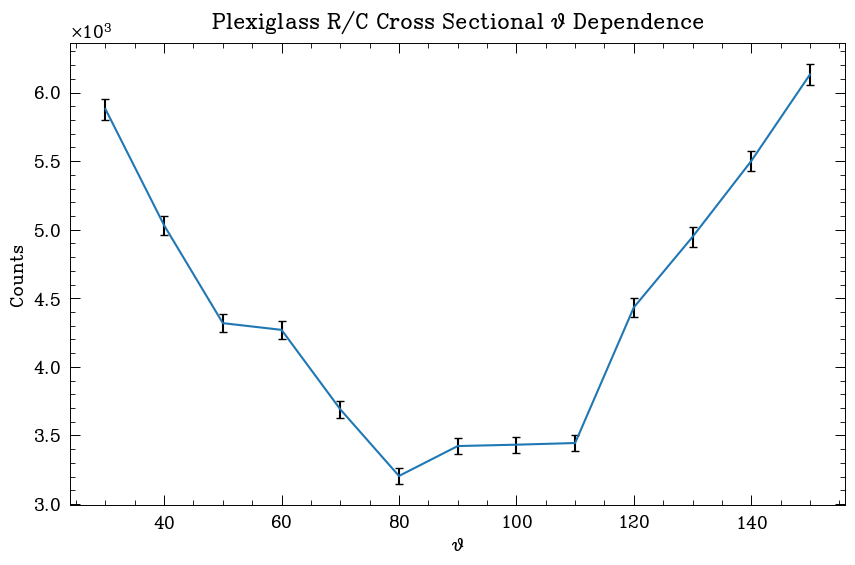

In [18]:
mus = {}
sigmas = {}
SDMs = {}

fileC = open("Plexiglass Cross Section Circle.txt", "w")

lines = ['Theta, Counts, Uncertainty\n']

integrals = []
errors = []

for n in ns:
    mu1 = pars[n][1]
    mu1_unc = perrs[n][1]
    sigma1 = pars[n][2]
    sigma1_unc = perrs[n][2]
    peaks,Es = peaks_modified[n]
    N = np.sum(peaks)
    print(N)
    print(sigma1)
    SDM = (sigma1)/np.sqrt(N)
    mus[n] = mu1
    sigmas[n] = sigma1
    SDMs[n] = min(mu1_unc,0.45)
    print(SDMs[n])
    lines.append('%f, %f, %f\n' % (n,N,np.sqrt(N)))
    integrals.append(N)
    errors.append(np.sqrt(N))
    
fileC.writelines(lines)
fileC.close()
print(lines)
    
plt.figure(figsize=(10,6))
plt.errorbar(ns,integrals,yerr=errors,ecolor='black')
plt.xlabel(r'$\theta$')
plt.ylabel('Counts')
plt.title(r'Plexiglass R/C Cross Sectional $\theta$ Dependence')
plt.show()

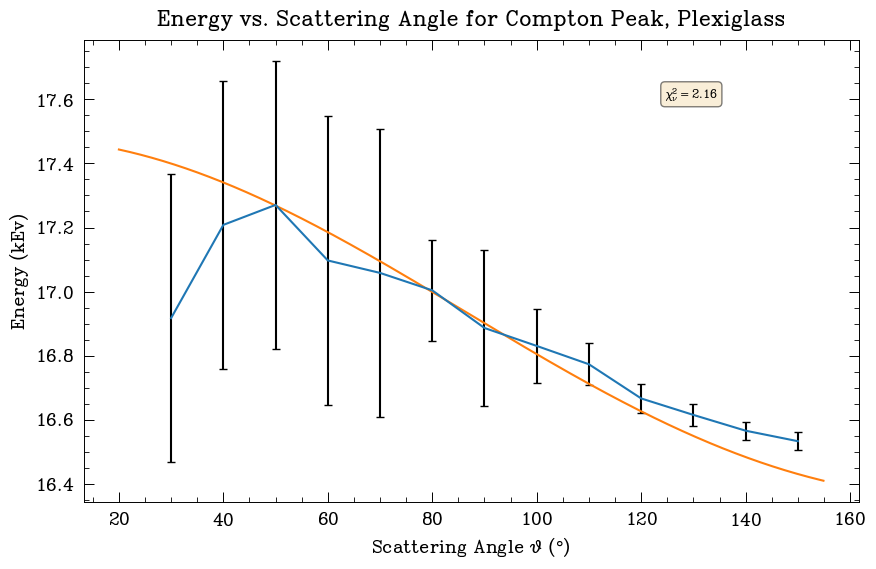

In [19]:
fig,ax = plt.subplots(figsize=(10,6))
ax.errorbar(list(mus.keys()),list(mus.values()),yerr=list(SDMs.values()),ecolor='black')
thetas = np.arange(20,155,0.1)
ax.plot(thetas,compton_shift(thetas, kA_Mo))

x = np.array(list(mus.keys()))
f = compton_shift(x, kA_Mo)
y = np.array(list(mus.values()))
y_err = np.array(list(SDMs.values()))
chi = red_chi_2(f,y,y_err)

textstr = r'$\chi^2_{\nu}=%.2f$' % chi

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.75, 0.90, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.title('Energy vs. Scattering Angle for Compton Peak, Plexiglass')
plt.xlabel(r'Scattering Angle $\theta$ ($\degree$)')
plt.ylabel('Energy (kEv)')
plt.show()